<font size="+3"><strong>3. Predicting Volatility</strong></font>

In the last notebook, we learned that one characteristic of stocks that's important to investors is **volatility**. Actually, it's so important that there are several time series models for predicting it. In this notebook, we'll build one such model called **GARCH**. We'll also continue working with assert statements to test our code.

In [ ]:
%%capture
!pip install python-dotenv
import os
from dotenv import load_dotenv

# Load variables from .env file
load_dotenv('env')

# Use variables
ALPHA_API_KEY = os.getenv('ALPHA_API_KEY')
DB_NAME = os.getenv('DB_NAME')
MODEL_DIRECTORY = os.getenv('MODEL_DIRECTORY')

In [ ]:
%%capture
!pip install arch
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch import arch_model
from config import settings
from data import SQLRepository
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Prepare Data

As always, the first thing we need to do is connect to our data source.

## Import

In [ ]:
# Create a connection to our database and then instantiate a `SQLRepository` named repo to interact with that database
connection = sqlite3.connect(settings.db_name, check_same_thread=False)
repo = SQLRepository(connection= connection)

print("repo type:", type(repo))
print("repo.connection type:", type(repo.connection))

repo type: <class 'data.SQLRepository'>
repo.connection type: <class 'sqlite3.Connection'>


Now that we're connected to a database, let's pull out what we need.

In [ ]:
# Pull the most recent 2,500 rows of data for TESCO from our database
df_tesco = repo.read_table(table_name="TSCO.LON", limit=2500)

print("df_tesco type:", type(df_tesco))
print("df_tesco shape:", df_tesco.shape)
df_tesco.head()

df_tesco type: <class 'pandas.core.frame.DataFrame'>
df_tesco shape: (2500, 5)


,open,high,low,close,volume
date,,,,,
2023-09-25,270.3,272.3000,267.400,268.8,8475620.0
2023-09-22,268.0,271.7944,267.300,270.9,14749700.0
2023-09-21,269.4,270.8000,267.951,269.5,51629281.0
2023-09-20,273.1,274.8000,268.900,270.5,16208980.0
2023-09-19,271.3,273.5000,271.000,273.1,17100000.0


In [ ]:
# Create a wrangle_data function whose output is the returns for a stock stored in our database
def wrangle_data(ticker, n_observations):

    """Extract table data from database. Calculate returns.

    Parameters
    ----------
    ticker : str
        The ticker symbol of the stock (also table name in database).

    n_observations : int
        Number of observations to return.

    Returns
    -------
    pd.Series
        Name will be `"return"`. There will be no `NaN` values.
    """
    # Get table from database
    df = repo.read_table(table_name=ticker,limit=n_observations +1)

    # Sort DataFrame ascending by date
    df.sort_index(ascending= True, inplace=True)

    # Create "return" column
    df["return"] = df["close"].pct_change() *  100

    # Return returns
    return df["return"].dropna()

Let's test our function, we'll also create a Series `y_tesco` that we'll use to train our model.

In [ ]:
y_tesco = wrangle_data(ticker="TSCO.LON", n_observations=2500)

# Is `y_tesco` a Series?
assert isinstance(y_tesco, pd.Series)

# Are there 2500 observations in the Series?
assert len(y_tesco) == 2500

# Is `y_tesco` name "return"?
assert y_tesco.name == "return"

# Does `y_tesco` have a DatetimeIndex?
assert isinstance(y_tesco.index, pd.DatetimeIndex)

# Is index sorted ascending?
assert all(y_tesco.index == y_tesco.sort_index(ascending=True).index)

# Are there no `NaN` values?
assert y_tesco.isnull().sum() == 0

y_tesco.head()

date
2013-10-31   -1.300813
2013-11-01   -0.219659
2013-11-04   -0.247661
2013-11-05    0.137931
2013-11-06    0.096419
Name: return, dtype: float64

Let's get the returns for HSBC Group, too.

In [ ]:
y_hsbc = wrangle_data(ticker="HSBA.L", n_observations=2500)

print("y_hsbc type:", type(y_hsbc))
print("y_hsbc shape:", y_hsbc.shape)
y_hsbc.head()

y_hsbc type: <class 'pandas.core.series.Series'>
y_hsbc shape: (2500,)


date
2013-11-05   -0.711238
2013-11-06   -0.644699
2013-11-07   -0.533526
2013-11-08    0.811830
2013-11-11    0.230083
Name: return, dtype: float64

## Explore

Let's recreate the volatility time series plot we made in the last lesson so that we have a visual aid to talk about what volatility is.

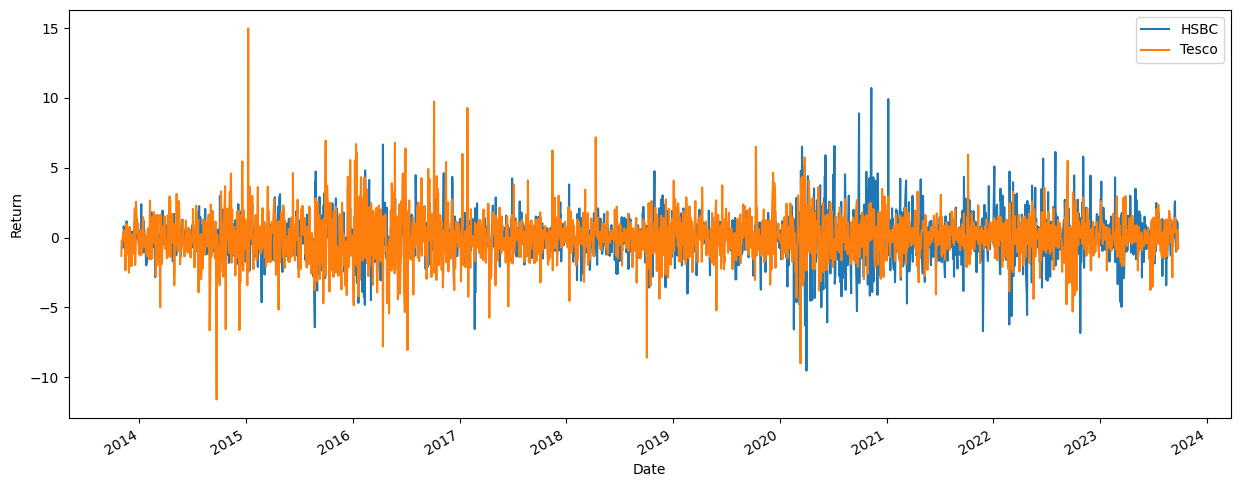

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for `y_hsbc` and `y_tesco`
y_tesco.plot(ax=ax, label="Tesco")
y_hsbc.plot(ax=ax, label="HSBC")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

The above plot shows how returns change over time. This may seem like a totally new concept, but if we visualize them without considering time, things will start to look familiar.

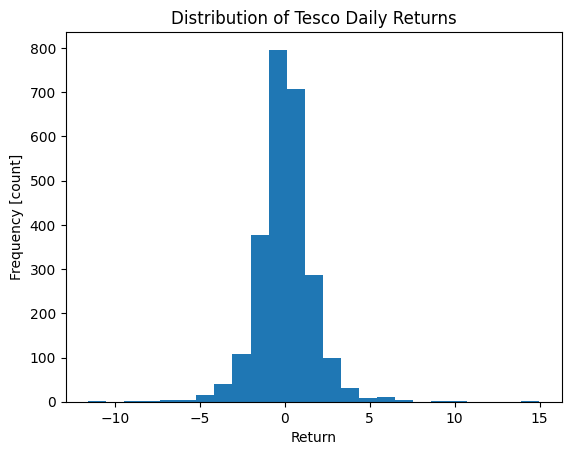

In [ ]:
# Create histogram of `y_tesco`, 25 bins
plt.hist(y_tesco, bins=25)

# Add axis labels
plt.xlabel("Return")
plt.ylabel("Frequency [count]")

# Add title
plt.title("Distribution of Tesco Daily Returns");

This is a familiar shape! It turns out that returns follow an almost normal distribution, centered on `0`. **Volatility** is the measure of the spread of these returns around the mean. In other words, volatility in finance is the same thing at standard deviation in statistics.

Let's start by measuring the daily volatility of our two stocks. Since our data frequency is also daily, this will be exactly the same as calculating the standard deviation.

In [ ]:
# Calculate daily volatility for HSBC and Tesco
hsbc_daily_volatility = y_hsbc.std()
tesco_daily_volatility = y_tesco.std()

print("HSBC Daily Volatility:", hsbc_daily_volatility)
print("Tesco Daily Volatility:", tesco_daily_volatility)

HSBC Daily Volatility: 1.5351229668237893
Tesco Daily Volatility: 1.618518567939802


In [ ]:
# Calculate the annual volatility for HSBC and Tesco
hsbc_annual_volatility = hsbc_daily_volatility * np.sqrt(252)
tesco_annual_volatility = tesco_daily_volatility * np.sqrt(252)

print("HSBC Annual Volatility:", hsbc_annual_volatility)
print("Tesco Annual Volatility:", tesco_annual_volatility)

HSBC Annual Volatility: 24.36932161271643
Tesco Annual Volatility: 25.69318573865469


Since we're dealing with time series data, another way to look at volatility is by calculating it using a rolling window.

In [ ]:
# Calculate the rolling volatility for y_tesco, using a 50-day window
tesco_rolling_50d_volatility = y_tesco.rolling(window=50).std().dropna()

print("rolling_50d_volatility type:", type(tesco_rolling_50d_volatility))
print("rolling_50d_volatility shape:", tesco_rolling_50d_volatility.shape)
tesco_rolling_50d_volatility.head()

rolling_50d_volatility type: <class 'pandas.core.series.Series'>
rolling_50d_volatility shape: (2451,)


date
2014-01-13    1.079883
2014-01-14    1.093838
2014-01-15    1.096111
2014-01-16    1.098226
2014-01-17    1.099577
Name: return, dtype: float64

This time, we'll focus on Tesco.

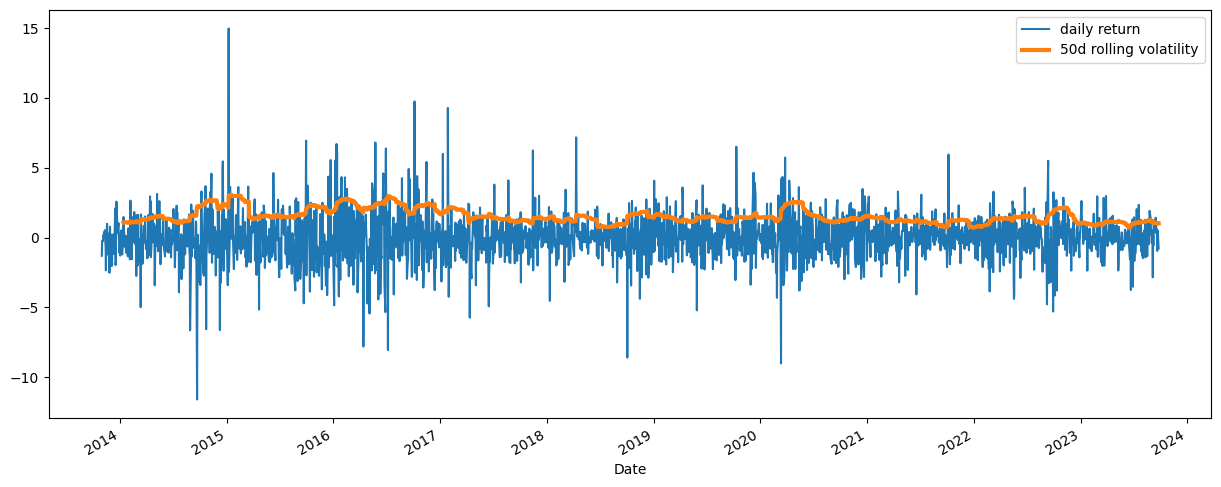

In [ ]:
# Create a time series plot showing the daily returns for Tesco and the 50-day rolling volatility
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_tesco`
y_tesco.plot(ax=ax, label="daily return")

# Plot `tesco_rolling_50d_volatility`
tesco_rolling_50d_volatility.plot(ax=ax, label="50d rolling volatility", linewidth=3)

# Add x-axis label
plt.xlabel("Date")

# Add legend
plt.legend();

Here we can see that volatility goes up when the returns change drastically — either up or down. For instance, we can see a big increase in volatility in May 2020, when there were several days of large negative returns. We can also see volatility go down in August 2021, when there are only small day-to-day changes in returns.

This plot reveals a problem. We want to use returns to see if high volatility on one day is associated with high volatility on the following day. But high volatility is caused by large changes in returns, which can be either positive or negative. How can we assess negative and positive numbers together without them canceling each other out? One solution is to take the absolute value of the numbers, which is what we do to calculate performance metrics like mean absolute error. The other solution, which is more common in this context, is to square all the values.  

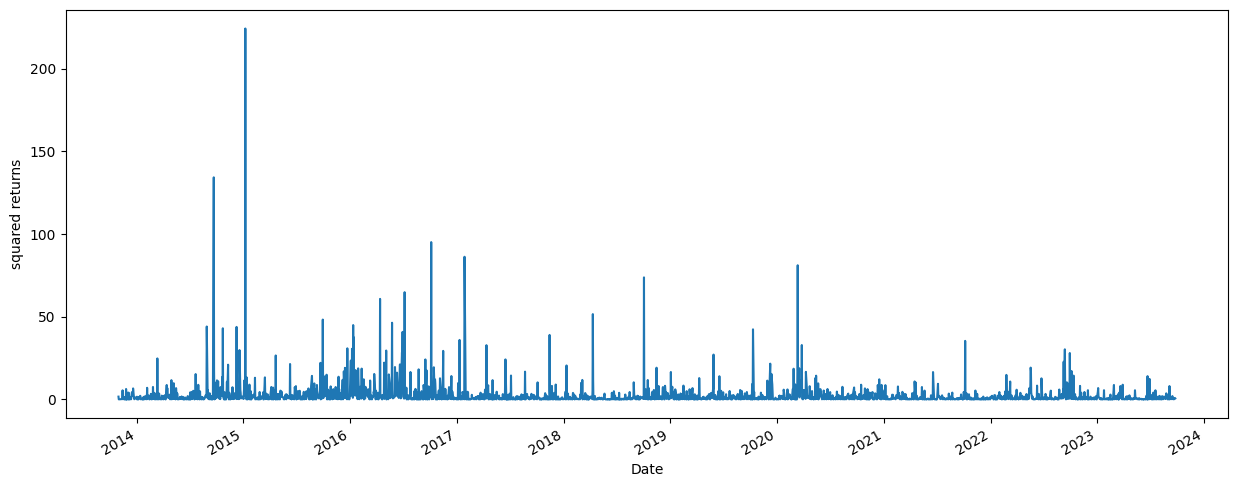

In [ ]:
# Create a time series plot of the squared returns in y_tesco
fig, ax = plt.subplots(figsize=(15, 6))

# Plot squared returns
(y_tesco**2).plot(ax=ax)

# Add axis labels
plt.xlabel("Date")
plt.ylabel("squared returns");

Now it's much easier to see that (1) we have periods of high and low volatility, and (2) high volatility days tend to cluster together. This is a perfect situation to use a GARCH model.

A GARCH model is sort of like the ARMA model. It has a `p` parameter handling correlations at prior time steps and a `q` parameter for dealing with "shock" events. It also uses the notion of lag. To see how many lags we should have in our model, we should create an ACF and PACF plot — but using the squared returns.

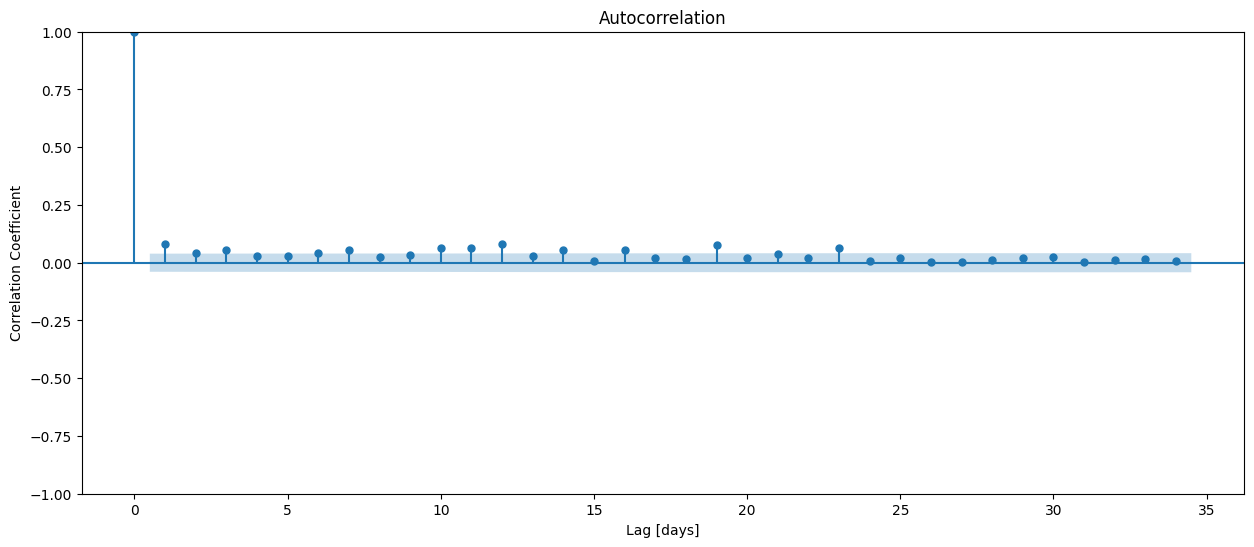

In [ ]:
# Create an ACF plot of squared returns for Tesco
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_acf(y_tesco**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

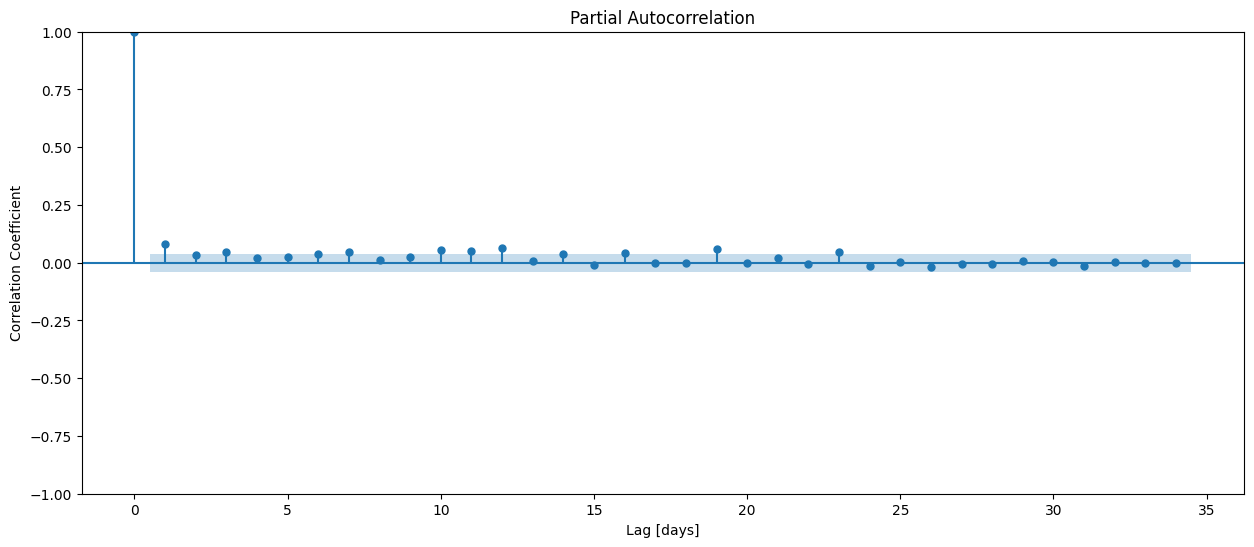

In [ ]:
# Create a PACF plot of squared returns for Tesco
fig, ax = plt.subplots(figsize=(15, 6))

# Create PACF of squared returns
plot_pacf(y_tesco**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

In our PACF, it looks like a lag of 3 would be a good starting point.

Normally, at this point in the model building process, we would split our data into training and test sets, and then set a baseline. Not this time. This is because our model's input and its output are two different measurements. We'll use **returns** to train our model, but we want it to predict **volatility**. If we created a test set, it wouldn't give us the "true values" that we'd need to assess our model's performance. So this time, we'll skip right to iterating.

## Split

The last thing we need to do before building our model is to create a training set. Note that we won't create a test set here. Rather, we'll use all of `y_tesco` to conduct walk-forward validation after we've built our model.

In [ ]:
# Create a training set y_tesco_train that contains the first 80% of the observations in y_tesco
cutoff_test = int(len(y_tesco) * 0.8)
y_tesco_train = y_tesco.iloc[:cutoff_test]

print("y_tesco_train type:", type(y_tesco_train))
print("y_tesco_train shape:", y_tesco_train.shape)
y_tesco_train.tail()

y_tesco_train type: <class 'pandas.core.series.Series'>
y_tesco_train shape: (2000,)


date
2021-09-22    1.730171
2021-09-23   -0.802599
2021-09-24   -0.789829
2021-09-27    0.155340
2021-09-28   -0.601008
Name: return, dtype: float64

# Build Model

## Iterate

In [ ]:
# Build and train model
model = arch_model(
    y_tesco_train,
    p=1,
    q=1,
    rescale=False
).fit(disp=0)
print("model type:", type(model))

# Show model summary
model.summary()

model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3796.17
Distribution:                  Normal   AIC:                           7600.33
Method:            Maximum Likelihood   BIC:                           7622.74
                                        No. Observations:                 2000
Date:                Tue, Sep 26 2023   Df Residuals:                     1999
Time:                        19:33:36   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         4.8727e-03  3.446e-02      0.141      0.888 [-6.267e-02,7.241e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0349  3.272e-02      1.066      0.287 [-2.925e-02,9.899e-02]
alpha[1]       0.0299  1.723e-02      1.735  8.282e-02 [-3.884e-03,6.366e-02]
beta[1]        0.9583  2.631e-02     36.430 1.432e-290      [  0.907,  1.010]
=============================================================================

Covariance estimator: robust
"""

In [ ]:
model.aic

7600.333765832602

In [ ]:
model.bic

7622.73737567077

Now that we've settled on a model, let's visualize its predictions, together with the Tesco returns.

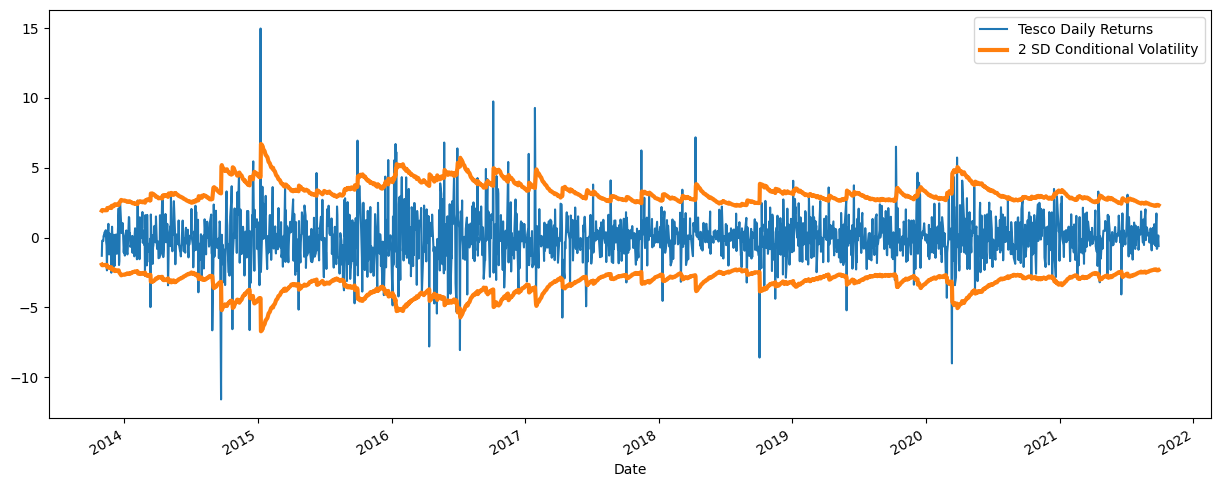

In [ ]:
# Create a time series plot with the Tesco returns and the conditional volatility for our model
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_tesco_train`
y_tesco_train.plot(ax=ax, label="Tesco Daily Returns")

# Plot conditional volatility * 2
(2 * model.conditional_volatility).plot(
    ax=ax, color="C1", label="2 SD Conditional Volatility", linewidth=3
)

# Plot conditional volatility * -2
(-2 * model.conditional_volatility.rename("")).plot(
    ax=ax, color="C1", linewidth=3
)
# Add axis labels
plt.xlabel("Date")


# Add legend
plt.legend();

Visually, our model looks pretty good, but we should examine residuals, just to make sure. In the case of GARCH models, we need to look at the standardized residuals.

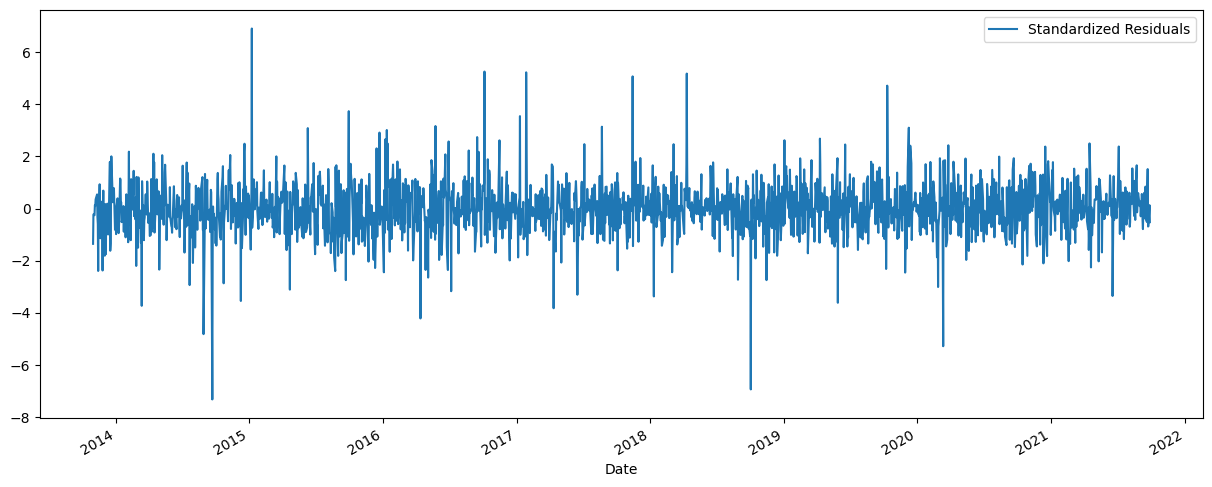

In [ ]:
# Create a time series plot of the standardized residuals for our model
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals
model.std_resid.plot(ax=ax, label="Standardized Residuals")

# Add axis labels
plt.xlabel("Date")


# Add legend
plt.legend();

These residuals look good: they have a consistent mean and spread over time. Let's check their normality using a histogram.

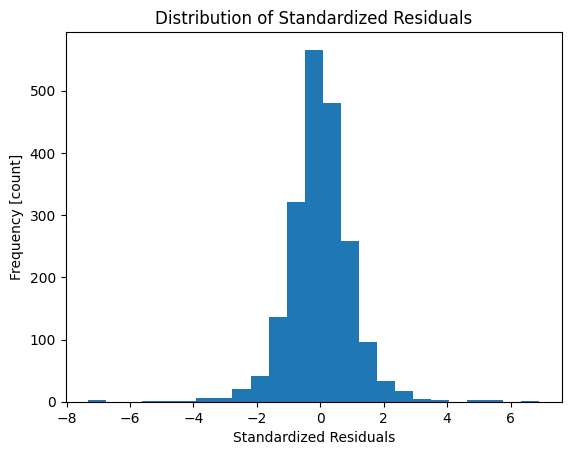

In [ ]:
# Create histogram of standardized residuals, 25 bins
plt.hist(model.std_resid, bins=25)

# Add axis labels
plt.xlabel("Standardized Residuals")
plt.ylabel("Frequency [count]")

# Add title
plt.title("Distribution of Standardized Residuals");

Our last visualization will the ACF of standardized residuals. Just like we did with our first ACF, we'll need to square the values here, too.

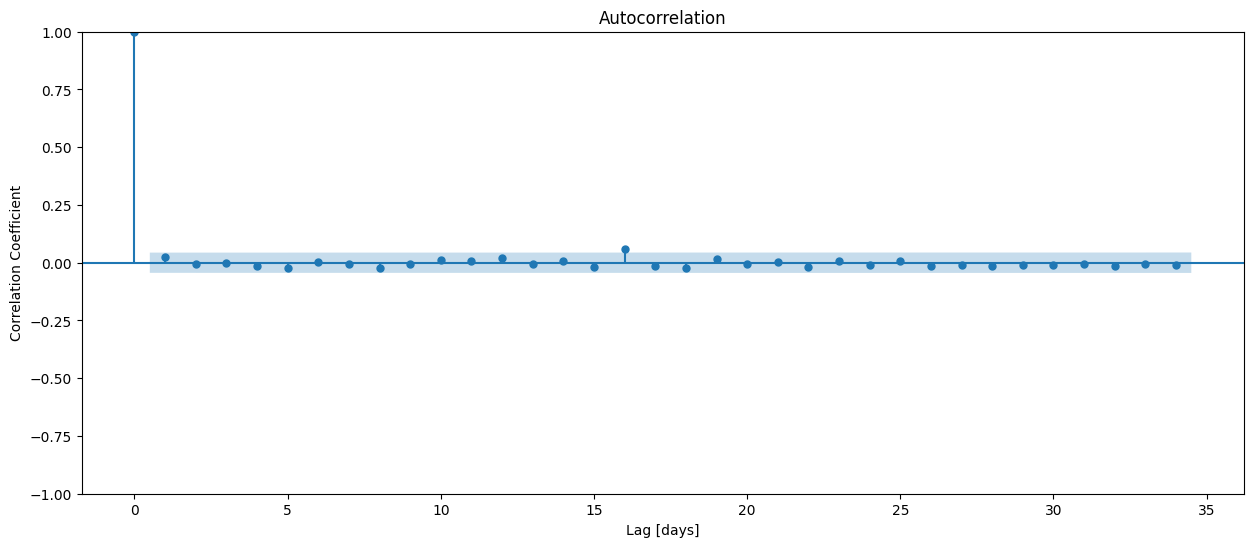

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

## Evaluate

To evaluate our model, we'll do walk-forward validation. Before we do, let's take a look at how this model returns its predictions.

In [ ]:
y_tesco_train.tail(1)

date
2021-09-28   -0.601008
Name: return, dtype: float64

In [ ]:
one_day_forecast = model.forecast(horizon=1, reindex=False).variance

print("one_day_forecast type:", type(one_day_forecast))
one_day_forecast

one_day_forecast type: <class 'pandas.core.frame.DataFrame'>


,h.1
date,
2021-09-28,1.334564


In [ ]:
one_day_forecast.iloc[0,0]**0.5

1.1552332440015005

There are two things we need to keep in mind here. First, our `model` forecast shows the predicted **variance**, not the **standard deviation** / **volatility**. So we'll need to take the square root of the value. Second, the prediction is in the form of a DataFrame. It has a DatetimeIndex, and the date is the last day for which we have training data. The `"h.1"` column stands for "horizon 1", that is, our model's prediction for the following day. We'll have to keep all this in mind when we reformat this prediction to serve to the end user of our application.

In [ ]:
# Create empty list to hold predictions
predictions = []

# Calculate size of test data (20%)
test_size = int(len(y_tesco) * 0.2)

# Walk forward
for i in range(test_size):
    # Create test data
    y_train = y_tesco.iloc[: -(test_size - i)]

    # Train model
    model = arch_model(y_train, p=1, q=1, rescale=False).fit(disp=0)

    # Generate next prediction (volatility, not variance)
    next_pred = model.forecast(horizon=1, reindex=False).variance.iloc[0,0] ** 0.5

    # Append prediction to list
    predictions.append(next_pred)

# Create Series from predictions list
y_test_wfv = pd.Series(predictions, index=y_tesco.tail(test_size).index)

print("y_test_wfv type:", type(y_test_wfv))
print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv.head()

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (500,)


date
2021-09-29    1.155233
2021-09-30    1.144392
2021-10-01    1.156614
2021-10-04    1.208394
2021-10-05    1.225794
dtype: float64

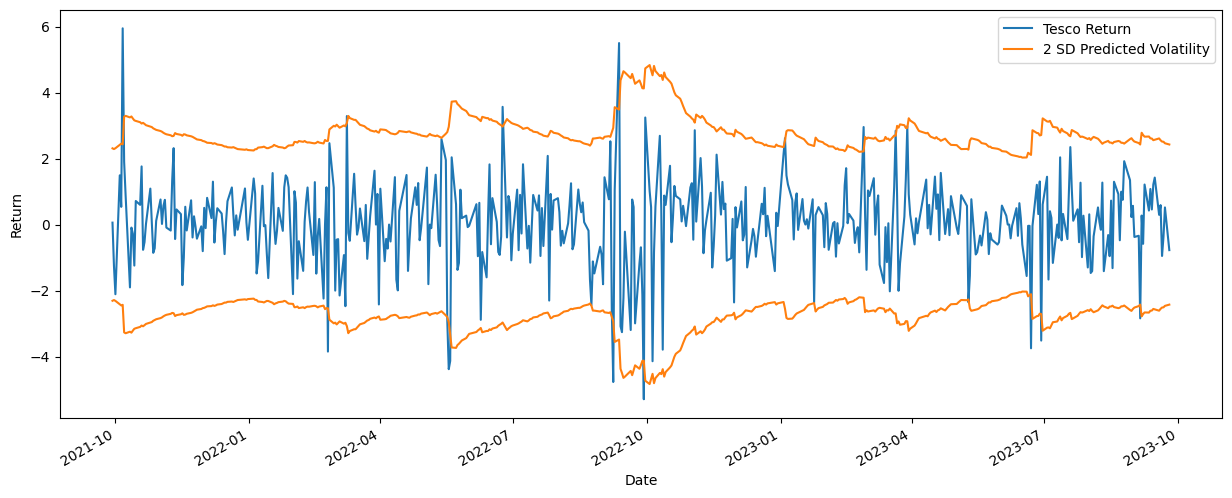

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for test data
y_tesco.tail(test_size).plot(ax=ax, label="Tesco Return")

# Plot volatility predictions * 2
(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2
(-2 * y_test_wfv).plot(ax=ax, c="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

This looks pretty good. Our volatility predictions seem to follow the changes in returns over time.



# Communicate Results

Normally in this section, we create visualizations for a human audience, but our goal for *this* project is to create an API for a *computer* audience. So we'll focus on transforming our model's predictions to JSON format, which is what we'll use to send predictions in our application.

The first thing we need to do is create a DatetimeIndex for our predictions. Using labels like `"h.1"`, `"h.2"`, etc., won't work. But there are two things we need to keep in mind. First, we can't include dates that are weekends because no trading happens on those days. And we'll need to write our dates using strings that follow the [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601) standard.

In [ ]:
# Generate 5-day volatility forecast
prediction = model.forecast(horizon=5, reindex=False).variance ** 0.5
print(prediction)

# Calculate forecast start date
start = prediction.index[0] + pd.DateOffset(days=1)

# Create date range
prediction_dates = pd.bdate_range(start=start, periods=prediction.shape[1])

# Create prediction index labels, ISO 8601 format
prediction_index = [d.isoformat() for d in prediction_dates]

print("prediction_index type:", type(prediction_index))
print("prediction_index len:", len(prediction_index))
prediction_index[:3]

                 h.1       h.2       h.3       h.4       h.5
date                                                        
2023-09-22  1.213652  1.228042  1.241903  1.255261  1.268142
prediction_index type: <class 'list'>
prediction_index len: 5


['2023-09-25T00:00:00', '2023-09-26T00:00:00', '2023-09-27T00:00:00']

Now that we know how to create the index, let's create a function to combine the index and predictions, and then return a dictionary where each key is a date and each value is a predicted volatility.

In [ ]:
def clean_prediction(prediction):

    """Reformat model prediction to JSON.

    Parameters
    ----------
    prediction : pd.DataFrame
        Variance from a `ARCHModelForecast`

    Returns
    -------
    dict
        Forecast of volatility. Each key is date in ISO 8601 format.
        Each value is predicted volatility.
    """
    # Calculate forecast start date
    start = prediction.index[0] + pd.DateOffset(days=1)

    # Create date range
    prediction_dates = pd.bdate_range(start=start, periods=prediction.shape[1])

    # Create prediction index labels, ISO 8601 format
    prediction_index = [d.isoformat() for d in prediction_dates]

    # Extract predictions from DataFrame, get square root
    data = prediction.values.flatten() ** 0.5

    # Combine `data` and `prediction_index` into Series
    prediction_formatted = pd.Series(data, index=prediction_index)

    # Return Series as dictionary
    return prediction_formatted.to_dict()

In [ ]:
prediction = model.forecast(horizon=10, reindex=False).variance
prediction_formatted = clean_prediction(prediction)

# Is `prediction_formatted` a dictionary?
assert isinstance(prediction_formatted, dict)

# Are keys correct data type?
assert all(isinstance(k, str) for k in prediction_formatted.keys())

# Are values correct data type
assert all(isinstance(v, float) for v in prediction_formatted.values())

prediction_formatted

{'2023-09-25T00:00:00': 1.2136521036002186,
 '2023-09-26T00:00:00': 1.2280418253853032,
 '2023-09-27T00:00:00': 1.2419025420856362,
 '2023-09-28T00:00:00': 1.2552609627968756,
 '2023-09-29T00:00:00': 1.2681418197286805,
 '2023-10-02T00:00:00': 1.2805680720375887,
 '2023-10-03T00:00:00': 1.292561082822493,
 '2023-10-04T00:00:00': 1.3041407735214023,
 '2023-10-05T00:00:00': 1.3153257591754892,
 '2023-10-06T00:00:00': 1.3261334674122291}